In [10]:
import torch
import torch.nn as nn
from sklearn.cluster import KMeans, AgglomerativeClustering
from model import *
import scipy.cluster.hierarchy as sch
import multiprocessing
import scipy.spatial.distance as ssd
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from sklearn import cluster
import time
from sklearn.decomposition import PCA
import pickle
# from sklearn.neighbors import NearestNeighbors
# from sklearn.model_selection  import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score,davies_bouldin_score, calinski_harabaz_score # 计算 轮廓系数，CH 指标，DBI 

In [11]:
def hierarchy_cluster(data, n_cluster, linkage, metric='euclidean', t=0.0001):
    cls = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage).fit(data)
    return cls.labels_


In [12]:
def k_means_cluster(data, n_cluster):
    model1 = KMeans(n_clusters=n_cluster, init="k-means++")
    model1.fit(data)
    labels = model1.labels_
    return labels

In [13]:
def get_two_hierarchical_cluster(data, n_cluster_1, max_num_every_cluster, mode_1=0, mode_2=0, metric='euclidean', linkage='ward'):
    np.random.seed(0)
    if type(data) != np.ndarray:
        if type(data) == torch.nn.modules.sparse.Embedding:
            data = data.weight.data.numpy()
    if mode_1 == 0:
        print('begin kmeans clustering level 1')
        cluster_1 = k_means_cluster(data, n_cluster_1)
    elif mode_1 == 1:
        print('begin hie clustering level 1')
        cluster_1 = hierarchy_cluster(data, n_cluster_1, linkage, metric)
    print(max(cluster_1))
        
    mid_c = {}
    for n, i in enumerate(cluster_1):
        if i not in mid_c:
            mid_c[i] = []
        mid_c[i].append(n)
    res = {}
    tot_c_num = 0
    print('begin clustering level 2')
    for i in mid_c:
        tmp = data[mid_c[i]]
        if mode_2 == 0:
            c_num = max(int(len(mid_c[i]) / max_num_every_cluster), 1)
            labels = k_means_cluster(tmp, c_num)
        elif mode_2 == 1:
            labels = hierarchy_cluster(tmp, c_num, linkage, metric)
            c_num = max(labels)
            labels -= 1
        for n,j in enumerate(mid_c[i]):
            res[j] = labels[n] + tot_c_num
        tot_c_num += c_num
    labels = []
    for i in range(14951):
        labels.append(res[i])
    return labels


In [14]:
def idx2define(data):
    fr_mid2idx = open('data/FB15k/_entity2index.txt')
    lines1 = fr_mid2idx.readlines()
    fr_mid2idx.close()
    idx2mid = {}
    for i in lines1:
        mid, idx = tuple(i.strip().split())
        idx = int(idx)
        idx2mid[idx] = mid
    fr_mid2name = open('data/fb_mid2name.txt')
    lines2 = fr_mid2name.readlines()
    fr_mid2name.close()
    mid2name = {}
    for i in lines2:
        tt = i.strip().split()
        try:
            mid, name = tt[0], tt[1]
            mid2name[mid] = name
        except Exception as e:
            pass
    res = {}
    for n, i in enumerate(data):
        if i not in res:
            res[i] = []
        try:
            res[i].append(mid2name[idx2mid[n]])
        except:
            pass
    return res
    
    

In [15]:
def save_cluster_info(labels, attr):
    if 'data' not in attr:
        raise Exception('there is no data info in attr.')
    if 'cluster_1' not in attr or 'cluster_2' not in attr:
        raise Exception('there is no cluster info in attr.')
    fname = 'cluster/' + '_'.join([attr['data'], attr['type'], str(attr['cluster_1'])]) + '.pkl'
    with open(fname, 'wb') as fw:
        l = pickle.dump(labels, fw)
    
        

In [16]:
def cal_cluster_score(data, label):
    ss = silhouette_score(data, label)
    dbs = davies_bouldin_score(data, label)
    chs = calinski_harabaz_score(data, label)
    return ss, dbs, chs

In [17]:
def random_create_clusters(total_num, min_per_cluster, max_per_cluster, dim=100, er=0.0001):
    cur_tot = 0
    res = []
    np.random.seed()
    cluster = 0
    while cur_tot < total_num:
        tmp_n = np.random.randint(min_per_cluster, max_per_cluster + 1)
        if cur_tot + tmp_n < total_num:
            cur_tot += tmp_n
        else:
            tmp_n = total_num - cur_tot
            cur_tot = total_num
        cluster += 1
        for i in range(tmp_n):
            arr = np.random.rand(dim)

            if np.random.random() >= 0.5:

                arr += np.random.random()*er
            else:

                arr -= np.random.random()*er
            res.append(arr)
    return np.array(res),cluster
        
                
            
        
    
    
    

In [18]:
ent_rr  = nn.Embedding(40943, 100) 
rel_rr = nn.Embedding(11, 100)
model = 'TransE'
dataset = 'WN18RR'
ent_rr.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_ent_emb.pkl'.format(model, dataset), map_location='cpu'))
rel_rr.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_rel_emb.pkl'.format(model, dataset), map_location='cpu'))
ent_rr_np = ent_rr.weight.data.numpy()
rel_rr_np = rel_rr.weight.data.numpy()
#FB15k-237
attr = {'data':'', 'type':'', 'cluster_1':0, 'cluster_2':0}
attr['type'] = 'rel'
attr['data'] = 'WN18RR'
with open('cluster/log_' + attr['data'] + '_' + attr['type'] + '.txt', 'w') as fw:
    tmp = rel_rr_np
    for i in range(2, 11):
        attr['cluster_1'] =  str(i) + model
        label = k_means_cluster(tmp, i)
#         label = hierarchy_cluster(tmp, i, linkage='complete')
        save_cluster_info(label, attr)
        ss, dbs, chs = cal_cluster_score(tmp, label)
        fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))





        
attr['type'] = 'ent'
attr['data'] = 'WN18RR'
with open('cluster/log_' + attr['data'] + '_' + attr['type'] + '.txt', 'w') as fw:
    tmp = ent_rr_np
    for i in range(1000, 41000, 3000):
        attr['cluster_1'] =  str(i) + model
        label = k_means_cluster(tmp, i)
#         label = hierarchy_cluster(tmp, i, linkage='complete')
        save_cluster_info(label, attr)
        ss, dbs, chs = cal_cluster_score(tmp, label)
        fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        




    







/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarni

2	0.400523	1.016695	4.868081

3	0.373558	0.761615	4.861767

4	0.360667	0.780999	5.524162

5	0.388866	0.231535	10.978343

6	0.224001	0.269805	12.072732

7	0.240028	0.219280	16.838158

8	0.265821	0.124291	63.251285

9	0.236973	0.035261	1585.192160



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


10	0.064999	0.082722	2764.125051



KeyboardInterrupt: 

In [15]:
ent_237  = nn.Embedding(14541, 100) 
rel_237 = nn.Embedding(237, 100)
model = 'DistMult'
dataset = 'FB15k-237'
ent_237.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_ent_emb.pkl'.format(model, dataset), map_location='cpu'))
rel_237.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_rel_emb.pkl'.format(model, dataset), map_location='cpu'))
ent_237_np = ent_237.weight.data.numpy()
rel_237_np = rel_237.weight.data.numpy()
#FB15k-237
attr = {'data':'', 'type':'', 'cluster_1':0, 'cluster_2':0}
attr['type'] = 'rel'
attr['data'] = 'FB15k-237'
with open('cluster/log_' + attr['data'] + '_' + attr['type'] + '.txt', 'w') as fw:
    tmp = rel_237_np
    for i in range(10, 230, 30):
        attr['cluster_1'] =  str(i) + model
        label = k_means_cluster(tmp, i)
#         label = hierarchy_cluster(tmp, i, linkage='complete')
        save_cluster_info(label, attr)
        ss, dbs, chs = cal_cluster_score(tmp, label)
        fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))





        
attr['type'] = 'ent'
attr['data'] = 'FB15k-237'
with open('cluster/log_' + attr['data'] + '_' + attr['type'] + '.txt', 'w') as fw:
    tmp = ent_237_np
    for i in range(1000, 15000, 1000):
        attr['cluster_1'] =  str(i) + model
        label = k_means_cluster(tmp, i)
#         label = hierarchy_cluster(tmp, i, linkage='complete')
        save_cluster_info(label, attr)
        ss, dbs, chs = cal_cluster_score(tmp, label)
        fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        




    






/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


10	0.037817	3.535094	5.217925

40	0.033505	2.036351	3.070851



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


70	0.052082	1.607841	2.767856



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


100	0.060151	1.203996	2.630660



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


130	0.068621	1.006398	2.786663



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


160	0.069843	0.906460	3.059719



KeyboardInterrupt: 

In [9]:
fb_ent_emb = nn.Embedding(14951, 100)
fb_rel_emb = nn.Embedding(1345, 100)

model = 'TransE'
dataset = 'FB15k'
fb_ent_emb.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_ent_emb.pkl'.format(model, dataset), map_location='cpu'))
fb_rel_emb.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_rel_emb.pkl'.format(model, dataset), map_location='cpu'))
fb_ent_numpy = fb_ent_emb.weight.data.numpy()
fb_rel_numpy = fb_rel_emb.weight.data.numpy()
#FB15k
attr = {'data':'', 'type':'', 'cluster_1':0, 'cluster_2':0}
attr['type'] = 'rel'
attr['data'] = 'FB15k'
        
with open('cluster/log_' + attr['data'] + '_' + attr['type'] + '.txt', 'w') as fw:
    tmp = fb_rel_numpy
    for i in range(100, 1400, 100):
        attr['cluster_1'] =  str(i)+ model
        label = k_means_cluster(tmp, i)
#         label = hierarchy_cluster(tmp, i, linkage='complete')
        save_cluster_info(label, attr)
        ss, dbs, chs = cal_cluster_score(tmp, label)
        fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))

attr['type'] = 'ent'
attr['data'] = 'FB15k'
with open('cluster/log_' + attr['data'] + '_' + attr['type'] + '.txt', 'w') as fw:
    for i in range(1000, 15000, 1000):
        attr['cluster_1'] =  str(i) + model
        tmp = fb_ent_numpy
        label = k_means_cluster(tmp, i)
#             label = hierarchy_cluster(tmp, i, linkage='complete')
        save_cluster_info(label, attr)
        ss, dbs, chs = cal_cluster_score(tmp, label)
        fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))

/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


100	0.085279	1.570827	12.230810



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


200	0.075407	1.159470	9.677635



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


300	0.065704	1.015121	9.388114



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


400	0.070756	0.871892	9.277311



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


500	0.073600	0.751407	9.693166



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


600	0.062381	0.653698	10.441479



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


700	0.058587	0.575762	11.678562



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


800	0.065109	0.513422	13.616921



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


900	0.062115	0.494908	16.545261



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1000	0.059493	0.405357	21.014865



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1100	0.043409	0.329657	30.330356



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1200	0.018679	0.243045	50.881037



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1300	0.012835	0.114880	192.162825



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1000	0.041614	2.827357	13.262056



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


2000	0.036318	2.293502	8.301436



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


3000	0.037458	1.919277	6.578330



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


4000	0.038785	1.616157	5.698542



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


5000	0.038996	1.412668	5.149196



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


6000	0.039928	1.220864	4.804933



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


7000	0.038991	1.089683	4.572982



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


8000	0.038082	0.960285	4.458837



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


9000	0.037618	0.854276	4.415532



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


10000	0.034511	0.756896	4.476532



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


11000	0.030903	0.663697	4.667118



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


12000	0.025493	0.571839	5.030895



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


13000	0.018006	0.465530	5.753475



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


14000	0.006727	0.372775	7.255459



In [19]:
#wn
wn_ent_emb = nn.Embedding(40943, 100)
wn_rel_emb = nn.Embedding(18, 100)
model = 'TransE'
dataset = 'wn'
wn_ent_emb.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_ent_emb.pkl'.format(model, dataset), map_location='cpu'))
wn_rel_emb.load_state_dict(torch.load('checkpoint/{}/{}/dim_100_rel_emb.pkl'.format(model, dataset), map_location='cpu'))
wn_ent_numpy = wn_ent_emb.weight.data.numpy()
wn_rel_numpy = wn_rel_emb.weight.data.numpy()
attr = {'data':'', 'type':'', 'cluster_1':0, 'cluster_2':0}
attr['type'] = 'rel'
attr['data'] = 'wn'
# with open('cluster/log_' + attr['data'] + '_' + attr['type'] + 'complete.txt', 'w') as fw:
#     tmp = wn_rel_numpy
#     for i in range(2, 18, 1):
#         attr['cluster_1'] = str(i) + model
#         label = k_means_cluster(tmp, i)
# #         label = hierarchy_cluster(tmp, i, linkage='complete')
#         save_cluster_info(label, attr)
#         ss, dbs, chs = cal_cluster_score(tmp, label)
#         fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
#         print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        
        
        
attr['type'] = 'ent'
attr['data'] = 'wn'
with open('cluster/log_' + attr['data'] + '_' + attr['type'] + 'complete.txt', 'w') as fw:
    tmp = wn_ent_numpy
    for i in range(40000, 42000, 3000):
        attr['cluster_1'] = str(i) + model
        label = k_means_cluster(tmp, i)
#         label = hierarchy_cluster(tmp, i, linkage='complete')
        save_cluster_info(label, attr)
        ss, dbs, chs = cal_cluster_score(tmp, label)
        fw.write("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
        print("{}\t{:.6f}\t{:.6f}\t{:.6f}\n".format(i, ss, dbs, chs))
    

/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


40000	0.018077	0.107884	88.958215



In [30]:
attr = {'data':'FB15k', 'type':'rel', 'cluster_1':'300_random', 'cluster_2':0}
label = [0 for i in range(1345)]
np.random.seed()
c = 300
for i in range(1345):
    k = np.random.randint(0, c)
    label[i] = k
save_cluster_info(label, attr)

In [31]:
attr = {'data':'FB15k', 'type':'rel', 'cluster_1':'300_complete', 'cluster_2':0}
label = hierarchy_cluster(fb_rel_numpy, 300, linkage='complete')
save_cluster_info(label, attr)

In [32]:
attr = {'data':'FB15k', 'type':'res', 'cluster_1':100, 'cluster_2':2}
labels = get_two_hierarchical_cluster(fb_ent_numpy, attr['cluster_1'], attr['cluster_2'], mode_1=1, mode_2=0)
save_cluster_info(labels, attr)

begin hie clustering level 1


KeyboardInterrupt: 

In [ ]:
arr.shape

In [ ]:
labels = k_means_cluster(fb_rel_numpy, 300)
attr = {'data':'FB15k', 'cluster_1':'50', 'cluster_2':'2'}
save_cluster_info(labels, attr)

In [67]:
disMat_fb.shape

(111758725,)

In [42]:
for i in labels:
    if labels == 0:
        print(labels)

In [238]:
disMat_fb_sig = sch.distance.pdist(fb_ent_numpy_sig,'euclidean') 
disMat_fb = sch.distance.pdist(fb_ent_numpy,'euclidean') 

In [232]:
disMat_wn = sch.distance.pdist(wn_ent_numpy,'euclidean')

16.379768763738387

In [327]:
disMat_fb_rel = sch.distance.pdist(fb_rel_numpy,'euclidean') 

In [336]:
method = 'complete'

Z=sch.linkage(disMat_fb_rel, method=method, metric='euclidean') 
cluster= sch.fcluster(Z, 1, 'inconsistent') 
print("Original cluster by hierarchy clustering:\n",cluster)
print(max(cluster))

attr = {'data':'FB15k', 'cluster_1':'rel', 'cluster_2':method}
save_cluster_info(cluster - 1, attr)


Original cluster by hierarchy clustering:
 [321 157 371 ... 248 233 274]
458


Original cluster by hierarchy clustering:
 [813  67  18 ... 146 146 284]


916

In [249]:
davies_bouldin_score(fb_ent_numpy, cluster)

/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.5814659629590252

In [257]:
min(cluster)

1

In [230]:
scores = []
p = 1
for i in range(12):
    p *= 2
    model1 = KMeans(n_clusters=p, init='k-means++', n_jobs=multiprocessing.cpu_count())
    model1.fit(fb_ent_numpy)
    scores.append(model1.inertia_)
    print(p, model1.inertia_)
    

2 536575.5927953108
4 501209.5412837497
8 469380.628139176
16 439559.0255583375
32 406493.38295257825
64 375317.9713624637
128 344063.58247729036
256 313196.2362896057
512 283076.5793945887
1024 251443.2723787214
2048 211970.25034122472


KeyboardInterrupt: 

In [ ]:
scores

In [371]:
tmp = nn.Embedding(14951, 100, padding_idx=0).weight.data
nn.init.xavier_normal_(tmp)

tensor([[ 1.4832e-02, -3.7083e-03, -1.6193e-02,  ..., -4.1934e-03,
          1.9490e-03, -5.5575e-03],
        [ 8.8506e-03, -8.0348e-03,  1.0615e-04,  ...,  3.2089e-03,
         -2.0138e-02,  7.0337e-03],
        [-3.0191e-03, -1.2472e-02,  3.8467e-03,  ...,  6.0615e-03,
         -6.6527e-03, -1.0175e-02],
        ...,
        [-9.1281e-03, -2.3295e-02,  2.2078e-02,  ...,  4.8424e-05,
          7.1982e-03,  1.1260e-02],
        [ 1.4788e-02, -3.0503e-03, -1.4691e-02,  ...,  4.1750e-03,
          6.2304e-03, -5.8676e-03],
        [-1.1520e-02,  3.3117e-03, -1.8467e-02,  ..., -8.0941e-03,
         -4.2978e-03, -2.5553e-02]])

In [109]:
np.random.seed(0)
new_tmp = s1_n
res = []
for i in range(10, 270, 10):
    
#     label1 = k_means_cluster(new_tmp,n_cluster=i)
    label1 = hierarchy_cluster(new_tmp,n_cluster=i,linkage='complete')
    res.append(cal_cluster_score(new_tmp, label1))
    attr = {'data':'countries_S1', 'cluster_1':i, 'cluster_2':0}
    save_cluster_info(label1, attr)



/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarn

/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarnin

In [110]:
res

[(0.045606468, 3.443670946658714, 5.889401626024606),
 (0.04643655, 2.610771982266275, 5.038594157067304),
 (0.06370298, 2.094174840135064, 4.578544409007477),
 (0.08620239, 1.716558599590916, 4.601633182186455),
 (0.10425042, 1.4232284007565223, 4.61600570187642),
 (0.10269699, 1.3243126376966683, 4.575070462750102),
 (0.10657505, 1.163292746761122, 4.475959611493796),
 (0.110779, 1.034497015945758, 4.422129583630747),
 (0.11853455, 0.9007186851226169, 4.535945451106836),
 (0.12625617, 0.8104846617341136, 4.663163995384482),
 (0.13682084, 0.7321411121035, 5.085982485942358),
 (0.14800772, 0.6901800122873732, 5.568613968004716),
 (0.14447753, 0.6310957725227808, 6.317340679319558),
 (0.15266146, 0.5978075317907029, 7.487420055828573),
 (0.16655019, 0.5457656309400843, 8.785648306413064),
 (0.16997026, 0.5001568737267054, 10.312527822048486),
 (0.16208823, 0.4566571360174973, 11.652050179616163),
 (0.14443378, 0.42850714493915115, 12.728195427983609),
 (0.12633874, 0.4046489333651306, 1

In [396]:
label2 = k_means_cluster(fb_ent_numpy,n_cluster=300)
t1 = silhouette_score(fb_ent_numpy, label2)
t2 = davies_bouldin_score(fb_ent_numpy, label2)
t3 = calinski_harabaz_score(fb_ent_numpy, label2)
print(t1, t2, t3)

0.058375068 3.0180546837410884 42.713833920344996


/Users/zhang/miniconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [69]:
x = [i for i in range(100, 1100, 100)]
y_base = [0.486, 0.490, 0.493, 0.495, 0.498, 0.500, 0.503, 0.504, 0.506, 0.507]
y_ent_5000 = [0.489, 0.496, 0.503, 0.509, 0.512, 0.516, 0.518, 0.520, 0.523, 0.525]
y_rel_300_random = [0.487, 0.492, 0.495, 0.500, 0.503, 0.505, 0.507, 0.509, 0.510, 0.511]
y_rel_300_complete = [0.488, 0.493, 0.497, 0.501, 0.505, 0.507, 0.509, 0.511, 0.512, 0.514]
y_rel_300_km = [0.487, 0.493, 0.497, 0.501, 0.504, 0.506, 0.509, 0.510, 0.512, 0.514]
y_ent_14000 = [0.491, 0.499, 0.506, 0.512, 0.515, 0.519, 0.522, 0.524, 0.525, 0.526]
mrr = [y_base, y_ent_5000, y_ent_14000,y_rel_300_km, y_rel_300_complete, y_rel_300_random]

In [70]:
h10_base = [82.7, 83.0, 83.4, 83.5, 83.7, 83.8, 83.9, 84.1, 84.1, 84.3]
h10_ent_5000 = [83.0, 83.4, 83.8, 84.0, 84.2, 84.3, 84.5, 84.6, 84.8, 84.9]
h10_rel_300_random = [82.7, 83.1, 83.5, 83.6, 83.7, 83.8, 84.0, 84.1, 84.2, 84.2]
h10_rel_300_complete = [82.7, 83.1, 83.5, 83.6, 83.8, 83.8, 84.0, 84.1, 84.2, 84.2]
h10_rel_300_km = [82.7, 83.1, 83.5, 83.6, 83.8, 83.8, 84.0, 84.1, 84.2, 84.2]
h10_ent_14000 = [83.0, 83.6, 83.8, 84.1, 84.2, 84.4, 84.6, 84.7, 84.8, 84.9]
h10 = [h10_base, h10_ent_5000, h10_ent_14000,h10_rel_300_km, h10_rel_300_complete, h10_rel_300_random]

In [71]:
h3_base = [63.9, 64.4, 64.8, 65.0, 65.3, 65.6, 65.9, 66.1, 66.2, 66.3]
h3_ent_5000 = [64.3, 65.1, 65.8, 66.4, 66.6, 67.0, 67.3, 67.5, 67.8, 67.8]
h3_rel_300_random = [63.9, 64.6, 65.0, 65.4, 65.7, 65.9, 66.1, 66.3, 66.5, 66.6]
h3_rel_300_complete = [64.0, 64.6, 65.0, 65.5, 65.7, 66.0, 66.2, 66.4, 66.5, 66.7]
h3_rel_300_km = [63.9, 64.7, 65.1, 65.4, 65.7, 66.0, 66.1, 66.4, 66.5, 66.7]
h3_ent_14000 = [64.4, 65.6, 66.3, 66.8, 67.0, 67.5, 67.7, 67.8, 68.0, 68.1]

h3 = [h3_base, h3_ent_5000, h3_ent_14000,h3_rel_300_km, h3_rel_300_complete, h3_rel_300_random]

In [72]:
h1_base = [28.4, 28.8, 29.0, 29.3, 29.6, 29.9, 30.2, 30.4, 30.5, 30.6]
h1_ent_5000 = [28.7, 29.5, 30.3, 30.9, 31.3, 31.7, 32.0, 32.2, 32.7, 32.8]
h1_rel_300_random = [28.6, 29.0, 29.4, 29.9, 30.3, 30.5, 30.8, 30.9, 31.0, 31.3]
h1_rel_300_complete = [28.6, 29.2, 29.6, 30.2, 30.6, 30.8, 31.1, 31.3, 31.4, 31.7]
h1_rel_300_km = [28.6, 29.1, 29.6, 30.1, 30.5, 30.7, 31.1, 31.2, 31.4, 31.7]
h1_ent_14000 = [28.8, 29.7, 30.5, 31.2, 31.6, 32.2, 32.5, 32.7, 32.8, 32.9]
h1 = [h1_base, h1_ent_5000, h1_ent_14000,h1_rel_300_km, h1_rel_300_complete, h1_rel_300_random]

In [73]:
import matplotlib.pyplot as plt

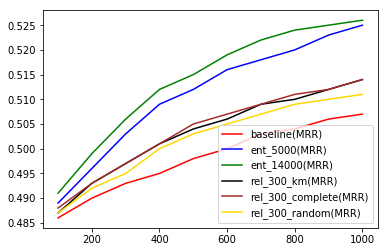

In [74]:
cl = ['red', 'blue', 'green', 'black', 'brown', 'gold']
name = "MRR"
for n, i in enumerate(mrr):
    plt.plot(x, i, c=cl[n])
plt.legend(["baseline({})".format(name),"ent_5000({})".format(name),"ent_14000({})".format(name), "rel_300_km({})".format(name), "rel_300_complete({})".format(name),"rel_300_random({})".format(name)])
plt.show()

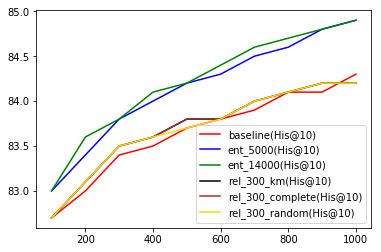

In [75]:

name = "His@10"
for n, i in enumerate(h10):
    
    plt.plot(x, i, c=cl[n])
plt.legend(["baseline({})".format(name),"ent_5000({})".format(name),"ent_14000({})".format(name), "rel_300_km({})".format(name), "rel_300_complete({})".format(name),"rel_300_random({})".format(name)])
plt.show()

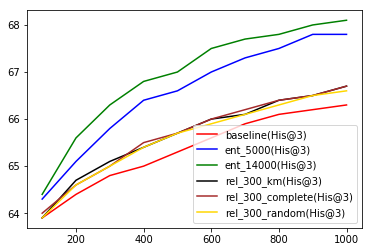

In [76]:

name = "His@3"
for n, i in enumerate(h3):
    
    plt.plot(x, i, c=cl[n])
plt.legend(["baseline({})".format(name),"ent_5000({})".format(name),"ent_14000({})".format(name), "rel_300_km({})".format(name), "rel_300_complete({})".format(name),"rel_300_random({})".format(name)])
plt.show()

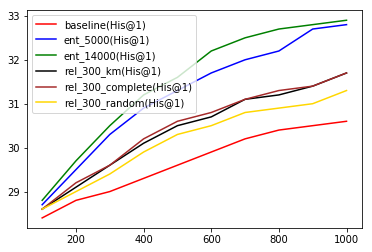

In [77]:

name = "His@1"
for n, i in enumerate(h1):
    
    plt.plot(x, i, c=cl[n])
plt.legend(["baseline({})".format(name),"ent_5000({})".format(name),"ent_14000({})".format(name), "rel_300_km({})".format(name), "rel_300_complete({})".format(name),"rel_300_random({})".format(name)])
plt.show()